In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [12]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_자전거수요예측/bike_train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_자전거수요예측/test.csv')
sample_submission = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_자전거수요예측/sampleSubmission.csv')

In [4]:
print(train.shape)
train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [14]:
# datetime 컬럼 datetime타입으로
train['datetime'] = train['datetime'].apply(pd.to_datetime)

# 년/월/일/시간 추출
train['year'] = train['datetime'].apply(lambda x : x.year)
train['month'] = train['datetime'].apply(lambda x : x.year)
train['day'] = train['datetime'].apply(lambda x : x.day)
train['hour'] = train['datetime'].apply(lambda x : x.hour)
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2011,1,2


In [15]:
drop_columns = ['datetime','casual','registered']
train.drop(drop_columns,axis=1,inplace=True)

In [21]:
# 평가함수
from sklearn.metrics import mean_squared_error,mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}".format(rmsle_val,rmse_val,mae_val))

In [22]:
# LinearRegression

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

y_target = train['count']
X_features = train.drop(['count'],axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE : 1.163, RMSE : 141.098, MAE : 105.859


In [29]:
# 실제값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어 오류 값이 가장 큰 순으로 5개확인
def get_top_error_data(y_test,pred,n_tops=5):
    result_df = pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff',ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            332.0  558.0
454          721            167.0  554.0
2314         766            213.0  553.0
3151         798            251.0  547.0
966          884            337.0  547.0


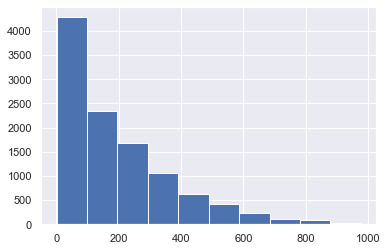

In [30]:
# 예측 오류가 크다. 타켓값의 분포가 왜곡된 형태를 이루고 있는지 확인하다
y_target.hist()

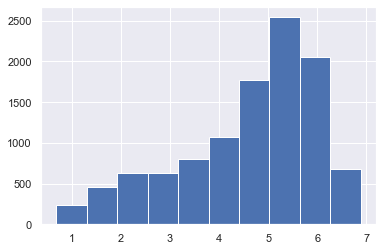

In [31]:
# target 변수에 로그변환을 시도한다
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [32]:
# 타겟변수 로그 변환 후 다시 학습

y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 분할
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target_log,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

# 결과이상함. year feature이 원핫인코딩 안되어있음

RMSLE : 1.019, RMSE : 164.249, MAE : 110.050


In [36]:
# one-hot encoding

X_features_ohe = pd.get_dummies(X_features,columns=['year','month','day','hour','holiday','workingday','season','weather'])

# 원핫인코딩, 로그변환 타겟변수 모두 반영하여 train/test split
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe,y_target_log,test_size=0.3,random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'##')
    evaluate_regr(y_test,pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)
    

### LinearRegression ##
RMSLE : 0.592, RMSE : 99.694, MAE : 64.175
### Ridge ##
RMSLE : 0.593, RMSE : 100.585, MAE : 64.726
### Lasso ##
RMSLE : 0.636, RMSE : 113.662, MAE : 73.054
